## Preliminaries

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

import clingo

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Problem (input)

- We have a road network with various nodes and edges between them.
- Some of these nodes are disabled (e.g., *road works*), but we don't know which one(s).
- We also have some information about cars that went from *a* to *b*, and what their shortest available path was.

The problem is to find a smallest set of disabled nodes such that all the paths that we have information about are indeed shortest (available) paths.

In [3]:
nodes = list(range(0, 12+1))
edges = [
    (0, 4),
    (4, 8),
    (8, 9),
    (0, 5),
    (5, 9),
    (1, 2),
    (1, 3),
    (2, 5),
    (2, 6),
    (2, 9),
    (6, 9),
    (3, 6),
    (3, 7),
    (7, 10),
    (10, 9),
    (10, 12),
    (9, 11),
    (9, 12),
    (12, 11),
]
paths = [
    # (begin, end, shortest_path)
    (0, 11, 4),
    (1, 12, 3),
    (3, 11, 4),
]
# paths = [
#     # (begin, end, shortest_path)
#     (0, 11, 8),
#     (1, 12, 4),
#     (3, 11, 4),
# ]


## Let's draw the graph

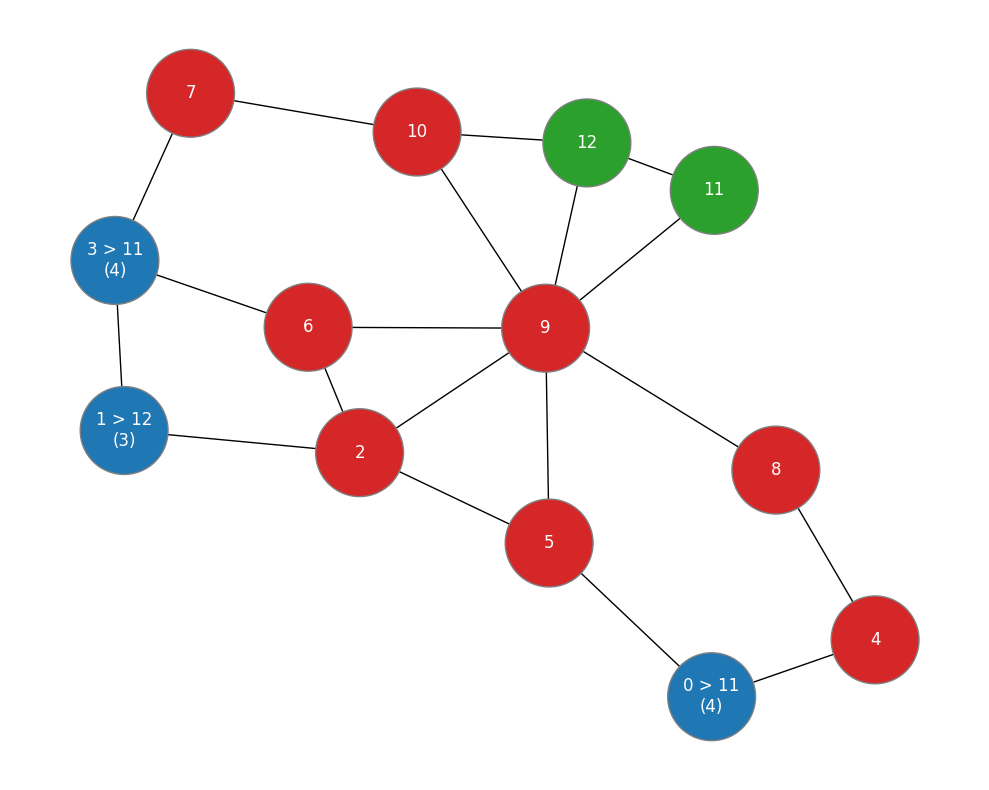

In [4]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (10, 8)
graph = nx.Graph()

ax = plt.gca()
ax.margins(0.08)

options = {
    "edgecolors": "tab:gray",
    "node_size": 4000,
    "font_color": "white",
    "font_size": 12,
}
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
layout = nx.spring_layout(graph, seed=41)

def node_label(node):
    for path in paths:
        if node == path[0]:
            return f"{node} > {path[1]}\n({path[2]})"
    return f"{node}"

labels = {
    node: node_label(node)
    for node in nodes
}

def node_color(node):
    if node in map(lambda x: x[0], paths):
        return "tab:blue"
    elif node in map(lambda x: x[1], paths):
        return "tab:green"
    else:
        return "tab:red"
colors = [
    node_color(node)
    for node in nodes
]

nx.draw(
    graph,
    layout,
    ax=ax,
    node_color=colors,
    labels=labels,
    with_labels=True,
    **options
)

plt.show()

## Let's solve it using ASP

Let's begin with encoding our problem input into facts.

In [5]:
asp_program = ""
for node in nodes:
    asp_program += f"node({node}).\n"
for edge in edges:
    asp_program += f"edge({edge[0]},{edge[1]}).\n"
asp_program += "edge(X,Y) :- edge(Y,X).\n"
for path in paths:
    asp_program += f"path({path[0]},{path[1]},{path[2]}).\n"

### Now let's encode the 'guess' part

In [6]:
asp_program += """
    { deactive(N) : node(N) }.
    #show deactive/1.
"""

### And then let's encode the 'check' part

In [7]:
asp_program += """
    num_active_nodes(Num) :- Num = #count { 1,N : active(N) }.
    
    active(N) :- node(N), not deactive(N).
    active_path_of_length(N,N,0) :- node(N), not deactive(N).
    active_path_of_length(N1,N3,I+1) :- active_path_of_length(N1,N2,I), edge(N2,N3),
        active(N1), active(N2), active(N3),
        num_active_nodes(Num), I < Num.

    :- path(N,M,I), not active_path_of_length(N,M,I).
    :- path(N,M,I), active_path_of_length(N,M,J), 0 <= J, J < I.

    #minimize { 1,deactive(N) : deactive(N) }.
"""

### And now let's call the solver :)

In [8]:
# Set solving timeout (0 means no timeout)
timeout = 0

# Ground the program
print("..Grounding..")
control = clingo.Control([])
control.add("base", [], asp_program)
control.ground([("base", [])])

# Solving settings
control.configuration.solve.models = 0
control.configuration.solve.opt_mode = "optN"

# Model printing
def interpret_model(model):
    if model.optimality_proven:
        print(f"{color.BOLD}Optimal answer set:{color.END} {model}")
    # else:
    #     print(f"{color.BOLD}Answer set:{color.END} {model}")        

# And solve!
if timeout > 0:
    print(f"..Solving with timeout {timeout}s..\n")
    with control.solve(
        async_=True,
        on_model=lambda model: interpret_model(model),
    ) as handle:
        finished = handle.wait(timeout)
        if not finished:
            print("..Stopped after timeout..")
        else:
            print("\n..Stopped..")
            time = control.statistics['summary']['times']['total']
            print(f"..Total solving time: {time:.2f} seconds..")
else:
    print("..Solving..\n")
    control.solve(
        on_model=lambda model: interpret_model(model),
    )
    print("\n..Stopped..")
    time = control.statistics['summary']['times']['total']
    print(f"..Total solving time: {time:.2f} seconds..")

..Grounding..
..Solving..

Optimal answer set: deactive(5) deactive(6)

..Stopped..
..Total solving time: 0.16 seconds..
